### Build Reproducible Experiments
In this notebook, the aim is to show you how to build a reproducible experiment within Azure. In this example, we're going to train a MNIST classifier using Tensorflow and show you how you can follow some practices to make this work reproducible. Later you can use this framework and apply it to other ML problems.

The reason we chose MNIST is to pick a very simple example as the main focus is to build a reproducible experiment and not to learn a new algorithm or to build a complex model.

**Important Note:**:

In order to practice all parts of the following Notebook, you first need to get a free Azure credit. If you don't have it, you can simply obtain it through this link: https://azure.microsoft.com/en-us/free/

You can run this notebook on your local latop, Azure Notebooks (notebooks.azure.com) or Notebook VMs:
- Local Laptop - the following packages has to be installed:
    - Azureml-SDK - with notebook,widget extensions
    - tensorflow==1.13
- Azure Notebooks:
    - This is a free notebook, all of the packages for an ML experiment is installed
- AzureML Notebook:
    - This is a premium notebook that you can choose the VM type. Avoid using this feature for the workshop as you may burn your credit before the end or the workshop.

Once you chose the execution environment, you need to create an Azure Machine Learning Service. Follow this instruction to build one:

The following text is copied from: https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-1st-experiment-sdk-setup#create-a-workspace


An Azure Machine Learning workspace is a foundational resource in the cloud that you use to experiment, train, and deploy machine learning models. It ties your Azure subscription and resource group to an easily consumed object in the service.

You create a workspace via the Azure portal, a web-based console for managing your Azure resources.

1. Sign in to the Azure portal by using the credentials for the Azure subscription you use.
1. In the upper-left corner of Azure portal, select + Create a resource.
1. Create a new resource
1. Use the search bar to find Machine Learning service workspace.
1. Select Machine Learning service workspace.
1. In the Machine Learning service workspace pane, select Create to begin.
1. Provide the following information to configure your new workspace:
    - **Field	Description**
    - **Workspace name**: type in **FirstExample**.
    - **Subscription**: Select the Azure subscription that you want to use. (Your free credit)
    - **Resource group**: type in **MLOpsWorkshop**
    - **Location**: type in **westus2**
1. After you are finished configuring the workspace, select Create.
When the process is finished, a deployment success message appears.
1. To view the new workspace, select Go to resource.


You can explore the resource from two view:
1. https://portal.azure.com (you can access all resources including Azure ML)
1. https://ml.azure.com (recently released - still in preview and dedicated to Azure ML)

First we download the MNIST sample files from Yann Lecun website to our development environment:

In [1]:
import os
import urllib

os.makedirs('./data/mnist', exist_ok=True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename = './data/mnist/train-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename = './data/mnist/train-labels.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename = './data/mnist/test-images.gz')
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename = './data/mnist/test-labels.gz')


('./data/mnist/test-labels.gz', <http.client.HTTPMessage at 0x1c6ee072448>)

Import a bunch of packages.

In [2]:
%matplotlib inline
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from azureml.widgets import RunDetails


Import the AzureML SDK package to be able to communicate with Azure ML Services

In [3]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)


SDK version: 1.0.83


In [4]:
# Your subscription ID will be different replace the stirng with yours
subscription_id = "3df1840f-dd4b-4f54-a831-e20536439b3a"
resource_group = "AzureML"
workspace_name = "MTDemoWUS2"
workspace_region = "westus2"

Initiate an object from Workspace class. the Workspace object will point to the created Workspace we created through the portal

In [5]:
# import the Workspace class and check the azureml SDK version
# exist_ok checks if workspace exists or not.

from azureml.core import Workspace

ws = Workspace(workspace_name = workspace_name,
               subscription_id = subscription_id,
               resource_group = resource_group)

# persist the subscription id, resource group name, and workspace name in aml_config/config.json.
ws.write_config()

In [6]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')


Workspace name: MTDemoWUS2
Azure region: westus2
Subscription id: 3df1840f-dd4b-4f54-a831-e20536439b3a
Resource group: AzureML


### Start a new Experiment

In software engineering world we have a new feature to develop. In ML/Data Science world, we work on experiments.

**Experiments** represent the collection of trials used to validate a user's hypothesis. We call each trial a run.

Here we create a new experiment, we want to make sure everything related to this experiment is saved within the workspace and the lineage between each artifact is preserved.

In [7]:
from azureml.core import Experiment

exp = Experiment(workspace=ws, name='at-manulife')

### 1. Track and Log Metrics

We have two ways to start a trail (Run). Interactively and through batch submite. The start_loggin() method is the interactive way of starting a trail. It returns a Run object that we can use to log important metrics or the trail.

The key metrics can a single value for the accuracy of an ML model, a list of values representing the distribution or the data or an image showing the confusion matrix.

In [8]:
# Initializing log tracking action by creating a Run object in the Experiment
run =  exp.start_logging()

In [9]:
run.get_status()

'Running'

Here you see that the **azureml.git.repository_uri** is poinint to the remote repo and the **azureml.git.branch** property is poining to the active branch.

In [10]:
run.get_details()

{'runId': 'd7d73f7d-a107-4ff7-9b35-2b265aa4e592',
 'target': 'sdk',
 'status': 'Running',
 'startTimeUtc': '2020-02-11T00:52:57.039037Z',
 'properties': {'azureml.git.repository_uri': 'https://github.com/classicboyir/exp-repro.git',
  'mlflow.source.git.repoURL': 'https://github.com/classicboyir/exp-repro.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '8431dc9407a3b7ce40ed7e7321568d825a2d02fe',
  'mlflow.source.git.commit': '8431dc9407a3b7ce40ed7e7321568d825a2d02fe',
  'azureml.git.dirty': 'True',
  'ContentSnapshotId': '31ec425e-68a3-4e6f-9ac8-d16053d8fb22'},
 'inputDatasets': [],
 'logFiles': {}}

In [12]:
from azureml.core import Run
# run = Run(experiment=exp, run_id='<get it from the result above>')

**RunDetails** class helps you visualize the active run object. It creates a network connection with Azure ML Worspace to collect everything happening during the run. It gets updated every 15 seconds.

In [13]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

**logs** function will log a single-valued or multi-valued metric under the current RUN. There are several types of logs, metric, table, row, image, etc.

Every time you add a new metric, check the widget above:

In [14]:
run.log('metric_1', 1.1)

In [15]:
run.log('metric_1', 2.0)

In [16]:
run.log('metric_1', 2.0)

In [17]:
run.log('metric_1', 4.0)

In [18]:
run.log('metric_1', 4.0)

In [19]:
run.log('metric_1', 2.5)

In [20]:
run.log('metric_1', 6.3)

In [21]:
# Log some metrics about the input dataset:

from utils import load_data

# Unzipping the input dataset and conver the data points into Numpy arrays
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster.
X_train = load_data('./data/mnist/train-images.gz', False) / 255.0
y_train = load_data('./data/mnist/train-labels.gz', True).reshape(-1)

X_test = load_data('./data/mnist/test-images.gz', False) / 255.0
y_test = load_data('./data/mnist/test-labels.gz', True).reshape(-1)

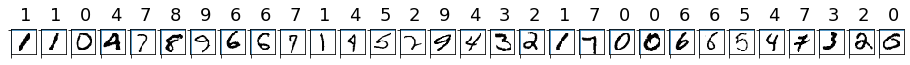

In [22]:
# Record how the input dataset looks like
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(28, 28), cmap = plt.cm.Greys)
    
run.log_image(name='{}-samples-of-input-dataset'.format(sample_size), plot=plt)

In [23]:
import pandas as pd
dist = pd.DataFrame(data=y_train, columns=['test_values'])['test_values'].value_counts()

run.log_table('digit_dist', {"count":list(dist.values), "digits":list(dist.index)})

In [24]:
X_train.shape

(60000, 784)

In [25]:
run.log('train_dataset_size', X_train.shape[0])

In [26]:
run.log('test_dataset_size', X_test.shape[0])

Get the collected metrics:

In [27]:
print('metric_1: ', run.get_metrics('metric_1'))
run.get_metrics()

metric_1:  {'metric_1': [1.1, 2, 2, 4, 4, 2.5, 6.3]}


{'metric_1': [1.1, 2, 2, 4, 4, 2.5, 6.3],
 '30-samples-of-input-dataset': 'aml://artifactId/ExperimentRun/dcid.d7d73f7d-a107-4ff7-9b35-2b265aa4e592/30-samples-of-input-dataset_1581382418.png',
 'digit_dist': {'count': [6742,
   6265,
   6131,
   5958,
   5949,
   5923,
   5918,
   5851,
   5842,
   5421],
  'digits': [1, 7, 3, 2, 9, 0, 6, 8, 4, 5]},
 'train_dataset_size': 60000,
 'test_dataset_size': 10000}

## 2. Data and Datasets

As an important part of experiment reproducibility, you'd like to separate your dataset from the training code and the development environment. There are two major ways that you can achieve this. First you can use datastores to define the connection to an Azure data store such as Blob, SQL or Databricks table, then you leverage Datasets to access the actual files and version the reference to those file assets.

### 2.1 Generate data references for the ML job

Once an ML Workspace is created, a storage account is created with a default container (a logical container that works as a folder - this is refered to as bucket in AWS S3). The container is attached to the Workspace automatically as the default storage account. You can find it as **workspaceblobstore** under Datastores (https://ml.azure.com). This storage account can be used for test and development but should not be used in production scenarios. Because if you decide to delete the Workspace, the default storage account is also deleted which results in losing your data. So it's wiser to create a separate storage account and attach it to the ML Workspace.

Here is how to access the default storage account:

In [28]:
# get_default_datastore returns the default datastore attached to the Workspace
ds = ws.get_default_datastore()

ds.name

'workspaceblobstore'

As the name of the default datastore suggestion, it's a reference to a Blob storage. Blob storage is a general purpose data lake that can be used to store any type of binary, from image, to csv file. Here are other types of Azure Storage types that you can attach to the WorkSpace:

- Azure File Share
- Azure Data Lake
- Azure Data Lake Gen2
- Azure SQL Database
- Azure PostgreSQL
- Databricks File System

The following is an example of registering (attaching) a new Blob storage account:

In [29]:
# from azureml.core.datastore import Datastore
# blob_datastore = Datastore.register_azure_blob_container(
#            workspace=ws,
#            datastore_name='<datastore_name>',
#            account_name='<account_name>', # Storage account name
#            container_name='<container_name>', # Name of Azure blob container
#            account_key='<account_key>')

Let's upload the files that I downloaded to this storage for longer retention. This datastore can be referenced later in my training job.

In [ ]:
ds.upload(src_dir='./data/mnist', target_path='mnist', overwrite=True, show_progress=True)

Uploading an estimated of 4 files
Uploading ./data/mnist\test-images.gz
Uploading ./data/mnist\test-labels.gz
Uploading ./data/mnist\train-images.gz
Uploading ./data/mnist\train-labels.gz
Uploaded ./data/mnist\test-labels.gz, 1 files out of an estimated total of 4
Uploaded ./data/mnist\train-labels.gz, 2 files out of an estimated total of 4


### 2.2 Generate Datasets

There are two different types of Datasets, TabularDataset and FileDataset. The Tabular can be used to access tabular like datasources, such as csv, SQL, Databricks, etc which FileDatasets can be used for binary datasets such as image, audio, etc. The following is a way to define a tabular dataset from an online source.

In [ ]:
from azureml.core.dataset import Dataset

# create a TabularDataset from a delimited file behind a public web url
web_path ='https://dprepdata.blob.core.windows.net/demo/Titanic.csv'
titanic_ds = Dataset.Tabular.from_delimited_files(path=web_path)

# To convert the Dataset into Spark (you need to have Spark installed on your development environment)
# titanic_ds.take(3).to_spark_dataframe()

# preview the first 3 rows of titanic_ds
titanic_ds.take(3).to_pandas_dataframe()

Datasets are references to a datasource (registered under datasources or available over internet). In other words, they don't keep the data, they are the reference definitiosn. You can register the defined Datasets under the Datasets section (accessible through ml.azure.com). Each time you register the dataset under the same name, you'll get a new version generated. Later you can access a particular version for the registered Dataset. As the dataset doesn't store your data, if you remove or change the data, the Dataset object doesn't help you roll back the change. Therefore, it's recommended to keep the data untouched. 

In order to keep the actual dataset, you can copy the data (using Azure Data Factory SDK or AzCopy CLI tool or [Azure SDK](https://github.com/Azure/azure-sdk-for-python/tree/master/sdk/storage/azure-storage-blob)) to clone the data to a new blob location and keep the under a new Dataset object.

In the following cells, I've generated two versions of the Dataset. Every version of the titanic_ds can have different reference structure.

In [ ]:
titanic_ds = titanic_ds.register(workspace = ws,
                                 name = 'titanic_ds',
                                 description = 'titanic training data',
                                 create_new_version = True)

In [ ]:
titanic_ds = titanic_ds.register(workspace = ws,
                                 name = 'titanic_ds',
                                 description = 'titanic training data',
                                 create_new_version = True)

At any time you can retrive a particular version of Dataset:

In [ ]:
titanic_ds_v1 = Dataset.get_by_name(workspace = ws,
                                 name = 'titanic_ds', 
                                 version = 1)

titanic_ds_v1.take(3).to_pandas_dataframe()

In [ ]:
# # Sample code to access Parquet files: link: https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-create-register-datasets
# 
# # create a TabularDataset with time series trait
# datastore_paths = [(datastore, 'weather/*/*/*/data.parquet')]
# 
# # get a coarse timestamp column from the path pattern
# dataset = Dataset.Tabular.from_parquet_files(path=datastore_path, partition_format='weather/{coarse_time:yyy/MM/dd}/data.parquet')
# 
# # set coarse timestamp to the virtual column created, and fine grain timestamp from a column in the data
# dataset = dataset.with_timestamp_columns(fine_grain_timestamp='datetime', coarse_grain_timestamp='coarse_time')
# 
# # filter with time-series-trait-specific methods
# data_slice = dataset.time_before(datetime(2019, 1, 1))
# data_slice = dataset.time_after(datetime(2019, 1, 1))
# data_slice = dataset.time_between(datetime(2019, 1, 1), datetime(2019, 2, 1))
# data_slice = dataset.time_recent(timedelta(weeks=1, days=1))

Now going back to our MNIST problem, let's create a Dataset object from the file uploaded to the default Datastore and register the Dataset:

In [ ]:
datastore_paths = [(ds, 'mnist/test-images.gz'),
 (ds, 'mnist/test-labels.gz'),
 (ds, 'mnist/train-images.gz'),
 (ds, 'mnist/train-labels.gz')]

mnist_dataset = Dataset.File.from_files(datastore_paths)
mnist_dataset

Now let's register it within the Datasets:

In [ ]:
mnist_dataset.register(workspace = ws,
                                 name = 'mnist_dataset',
                                 description = 'MNIST input dataset',
                                 create_new_version = True)

You define a new Dataset under **mnist_dataset** by accessing the actual file over the internet:

In [ ]:
web_paths = [
            'http://lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
            'http://lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
            'http://lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
            'http://lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz'
            ]

mnist_dataset_web = Dataset.File.from_files(path = web_paths)

mnist_dataset_web.register(workspace = ws,
                                 name = 'mnist_dataset',
                                 description = 'MNIST input dataset',
                                 create_new_version = True)

In [ ]:
mnist_dataset_v1 = Dataset.get_by_name(workspace = ws,
                                 name = 'mnist_dataset', 
                                 version = 1)

In [ ]:
# get the list of registered files back
mnist_dataset_v1.to_path()

To increase the level of flexibility, I create a different dataset for each file:

In [ ]:
datastore_path_test_images = [(ds, 'mnist/test-images.gz')]
datastore_path_test_labels = [(ds, 'mnist/test-labels.gz')]
datastore_path_train_images = [(ds, 'mnist/train-images.gz')]
datastore_path_train_labels = [(ds, 'mnist/train-labels.gz')]

dataset_test_images = Dataset.File.from_files(datastore_path_test_images)
dataset_test_images.register(workspace=ws, name='mnist_test_images', description='MNIST input dataset for test images', create_new_version = True)

dataset_test_labels = Dataset.File.from_files(datastore_path_test_labels)
dataset_test_labels.register(workspace=ws, name='mnist_test_labels', description='MNIST input dataset for test labels', create_new_version = True)

dataset_train_images = Dataset.File.from_files(datastore_path_train_images)
dataset_train_images.register(workspace=ws, name='mnist_train_images', description='MNIST input dataset for train images', create_new_version = True)

dataset_train_labels = Dataset.File.from_files(datastore_path_train_labels)
dataset_train_labels.register(workspace=ws, name='mnist_train_labels', description='MNIST input dataset for train labels', create_new_version = True)


Now check the ml.azure.com portal to check whether the datasets are registered or not.

In [ ]:
!git add . && git commit -m "added datasets and versioned them"

In [ ]:
run.complete()

## 3. Train ML Model in a Reproducible Way

### 3.1 Traditional way of running a experiment
Now run a simple Tensorflow job here to train an image classifier base off of MNIST dataset. This example requires Tensorflow 1.13.

This is a simple two later fully connected neural net:

In [ ]:
import numpy as np
import argparse
import os
import tensorflow as tf
from utils import load_data

data_folder = os.path.join('data', 'mnist')

print('training dataset is stored here:', data_folder)

training_set_size = X_train.shape[0]

n_inputs = 28 * 28
n_h1 = 100
n_h2 = 100
n_outputs = 10
learning_rate = 0.01
n_epochs = 20
batch_size = 50

with tf.name_scope('network'):
    # construct the DNN
    X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
    y = tf.placeholder(tf.int64, shape=(None), name='y')
    h1 = tf.layers.dense(X, n_h1, activation=tf.nn.relu, name='h1')
    h2 = tf.layers.dense(h1, n_h2, activation=tf.nn.relu, name='h2')
    output = tf.layers.dense(h2, n_outputs, name='output')

with tf.name_scope('train'):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=output)
    loss = tf.reduce_mean(cross_entropy, name='loss')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(output, y, 1)
    acc_op = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):

        # randomly shuffle training set
        indices = np.random.permutation(training_set_size)
        X_train = X_train[indices]
        y_train = y_train[indices]

        # batch index
        b_start = 0
        b_end = b_start + batch_size
        for _ in range(training_set_size // batch_size):
            # get a batch
            X_batch, y_batch = X_train[b_start: b_end], y_train[b_start: b_end]

            # update batch index for the next batch
            b_start = b_start + batch_size
            b_end = min(b_start + batch_size, training_set_size)

            # train
            sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        # evaluate training set
        acc_train = acc_op.eval(feed_dict={X: X_batch, y: y_batch})
        # evaluate validation set
        acc_val = acc_op.eval(feed_dict={X: X_test, y: y_test})

        print(epoch, '-- Training accuracy:', acc_train, '\b Validation accuracy:', acc_val)
        y_hat = np.argmax(output.eval(feed_dict={X: X_test}), axis=1)
    
    print('Final accuracy (val): ', acc_val)
    os.makedirs('./outputs/model', exist_ok=True)
    # files saved in the "./outputs" folder are automatically uploaded into run history
    saver.save(sess, './outputs/model/mnist-tf.model')


### 3.2 Make this job more reproducible - Still not ideal

A better way to train this NN model is to track the metrics (the better approach will be discussed later today)

**Tracking the metrics**

In [ ]:
exp = Experiment(workspace=ws, name='Train-TF-Locally')
run = exp.start_logging()

In [ ]:
run.get_details()

In [ ]:
RunDetails(run).show()

Log Hyper Parameters and Accuracy metrics for each epoch. Finally I collect the accuracy for the final epoch as the final accuracy metric.

Then I upload the model into the output section of the Experiment.

In [ ]:
run.log_row('Hyper Parameters',
        n_inputs=n_inputs,
        n_h1=n_h1,
        n_h2=n_h2,
        n_outputs=n_outputs,
        learning_rate=learning_rate,
        n_epochs=n_epochs,
        batch_size=batch_size)

In [ ]:
dataset_test_images = Dataset.get_by_name(workspace = ws, name = 'mnist_test_images')
dataset_test_labels = Dataset.get_by_name(workspace = ws, name = 'mnist_test_labels')
dataset_train_images = Dataset.get_by_name(workspace = ws, name = 'mnist_train_images')
dataset_train_labels = Dataset.get_by_name(workspace = ws, name = 'mnist_train_labels')

In [ ]:
run.log_row('dataset_test_images', dataset_name='mnist_test_images', version=dataset_train_labels.version)
run.log_row('dataset_test_labels', dataset_name='mnist_test_labels', version=dataset_train_labels.version)
run.log_row('dataset_train_images', dataset_name='mnist_train_images', version=dataset_train_labels.version)
run.log_row('dataset_train_labels', dataset_name='mnist_train_labels', version=dataset_train_labels.version)

In [ ]:
dataset_test_images.download('data/from_dataset')
dataset_test_labels.download('data/from_dataset')
dataset_train_images.download('data/from_dataset')
dataset_train_labels.download('data/from_dataset')

Getting the latest version of registered Dataset:

In [ ]:
X_train = load_data('./data/from_dataset/train-images.gz', False) / 255.0
y_train = load_data('./data/from_dataset/train-labels.gz', True).reshape(-1)
X_test = load_data('./data/from_dataset/test-images.gz', False) / 255.0
y_test = load_data('./data/from_dataset/test-labels.gz', True).reshape(-1)

In [ ]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):

        # randomly shuffle training set
        indices = np.random.permutation(training_set_size)
        X_train = X_train[indices]
        y_train = y_train[indices]

        # batch index
        b_start = 0
        b_end = b_start + batch_size
        for _ in range(training_set_size // batch_size):
            # get a batch
            X_batch, y_batch = X_train[b_start: b_end], y_train[b_start: b_end]

            # update batch index for the next batch
            b_start = b_start + batch_size
            b_end = min(b_start + batch_size, training_set_size)

            # train
            sess.run(train_op, feed_dict={X: X_batch, y: y_batch})
        
        # evaluate training set
        acc_train = acc_op.eval(feed_dict={X: X_batch, y: y_batch})
        run.log('accuracy-train', acc_train)
        # evaluate validation set
        acc_val = acc_op.eval(feed_dict={X: X_test, y: y_test})
        run.log('accuracy-val', acc_val)

        print(epoch, '-- Training accuracy:', acc_train, '\b Validation accuracy:', acc_val)
        y_hat = np.argmax(output.eval(feed_dict={X: X_test}), axis=1)
    
    print('Final accuracy (val): ', acc_val)
    run.log('final-accuracy', acc_val)
    os.makedirs('./outputs/model', exist_ok=True)
    # files saved in the "./outputs" folder are automatically uploaded into run history
    saver.save(sess, './outputs/model/mnist-tf.model')
    run.upload_folder('/outputs/model/', './outputs/')

In [ ]:
# Collect all or one of the metrics:

run.get_metrics()

In [ ]:
run.complete()

### 3.3 A better way to submit the TF job

Instead of running the TF job on our local laptop (or notebooks.azure.com) there is an easier way to accomplish this task. You can:
1. Create a remote compute - this can be a single VM, a set of VM (Azure ML Compute), Databricks or HDInsight Cluster (Spark).
1. Instead of we dealing with the depandancies, we let Azure ML manage the dependencies. In other words, We tell it what is the type of script, whether it's TF, Pytorch or just a python script and we let Azure set up the create remote compute instance for us.
1. We mount the dataset we created above to the compute node and we let Azure stream the data from the storage to the node
1. We ask Azure to register the model into a Model management instead of the output folder

#### Infra as Code: Creating a remote computer

With a couple of lines, we create a GPU cluster ([NV6 "1 NVIDIA Tesla M60"](https://docs.microsoft.com/en-us/azure/virtual-machines/windows/sizes-gpu#nv-series)) of 1 node. (We set it to 1 as we don't want to burn the credit - in real production settings we go with much larger VM size and much more than 1 node)

In [ ]:
# Create a GPU cluster of type NV6 with 1 node. (due to subscription's limitations we stick to 1 node)

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpuclusterNV"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    # CPU: Standard_D3_v2
    # GPU: Standard_NV6
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NV6', 
                                                           max_nodes=1,
                                                           min_nodes=1)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

In [ ]:
# compute_target.delete()

In [ ]:
AmlCompute.provisioning_configuration?

In [ ]:
# List of compute targets

compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

Steps from now:
1. Create a train.py file which keeps contains the training code for the MNIST TF file
    1. At the beginning of the train.py we define the arguments that we want to pass to the training file
1. It has all of the other dependencies such as util.py
1. We create a dictionary object that keeps all of the parameters need to be passed to the train.py
1. We define an estimator object from azureml.train.dnn.TensorFlow

In [ ]:
# Defining the project-folder that keeps all of the files required to be passed to the remote node

import os
script_folder = os.path.join(os.getcwd(), "project-folder")
os.makedirs(script_folder, exist_ok=True)
print(script_folder)

#### Providing the dataset as an input parameter

One of the ways to make the training job flexible is to provide parameters instead of counting on hardcoded values. One of the important values is the data folder. As we've discussed the two ways of providing data to the ML Workspace (Datastores and Datasets) you can similarly provide both to your training job. In the example below, we have demostrated both method. As the Datasets requires us to install extra packages on the remote compute and this takes us longer to execute, we chose to use the Datastore for this example.

The as_mount function connects the dataset or datastore to the target compute at the run time, makes it look like accessing the files as if an external storage is mounted to the remote compute. This is very efficient, as it doesn't bring un-accessed data into the remote compute.

The other options is to call as_download function, but it requires the remote compute to fiest download the entire data within datastore or dataset before running the script.

In [ ]:
from azureml.train.dnn import TensorFlow

script_params = {
    # You can provide the path from the Data Store or
    '--data-folder': ws.get_default_datastore().as_mount(),
    # Provide the mount point to the latest version of the registered dataset. If you choose Dataset instead of Datastore,
    # you need to install azureml-dataprep[fuse,pandas] on the compute node using pip_packages parameter "pip_packages=['azureml-dataprep[fuse,pandas]']"
    # '--dataset-test-images': dataset_test_images.as_named_input('mnist').as_mount(),
    # '--dataset-test-labels': dataset_test_labels.as_named_input('mnist').as_mount(),
    # '--dataset-train-images': dataset_train_images.as_named_input('mnist').as_mount(),
    # '--dataset-train-labels': dataset_train_labels.as_named_input('mnist').as_mount(),
    '--batch-size': 50,
    '--first-layer-neurons': 300,
    '--second-layer-neurons': 100,
    '--learning-rate': 0.01
}

est = TensorFlow(source_directory=script_folder,
                 script_params=script_params,
                 compute_target=compute_target,
                 entry_script='tf_mnist.py',
                 # pip_packages=['azureml-dataprep[fuse,pandas]'],
                 # pip_packages = ['pandas', 'numpy', '...']
                 # conda_packages = ['pandas', 'numpy', '...']
                 use_gpu=True, 
                 framework_version='1.13')

In [ ]:
run = exp.submit(est)
run

In [ ]:
RunDetails(run).show()

In [ ]:
# run.cancel()

In addition to **Tensorflow** class, you can submit Python script with **Pytorch**, **Chainer**, **SKLearn** and pure **PythonScript** classes to the remote **compute target**. Further reading: https://github.com/Azure/AzureML-Containers

In [ ]:
TensorFlow?

### 3.4 Register the model into the Model Registry

The Run object can access to the output folder that is saved under the current Run within the experiment. By using the register_model function, you can register the model under the Model tab of the Workspace.

In [ ]:
run.register_model(model_name='tf-dnn-mnist-single-run', model_path='outputs/model')

### 3.5 Environment Logging and Reproducibility

When the script is submitted using an Estimator object, Azure ML deploys a GPU base Linux docker image on the remote compute and based on the pip_packages and conda_packages parameters you can reproduce the environment as you wish.

Once the Run is submitted, the entire environment dependencies are logged and can be reproduced. Using the Run Details, you can explore the docker, conda and other dependencies.

In [ ]:
run.get_details()

You can also explicitly define the characteristics of the environment trhrough **RunConfiguration** class and provide it to the ScriptSubmit

In [ ]:
# from azureml.core.runconfig import RunConfiguration
# from azureml.core.conda_dependencies import CondaDependencies
# from azureml.core.runconfig import DEFAULT_CPU_IMAGE
# 
# # create a new runconfig object
# run_config = RunConfiguration()
# 
# # enable Docker 
# run_config.environment.docker.enabled = True
# 
# # set Docker base image to the default CPU-based image
# run_config.environment.docker.base_image = DEFAULT_CPU_IMAGE
# 
# # use conda_dependencies.yml to create a conda environment in the Docker image for execution
# run_config.environment.python.user_managed_dependencies = False
# 
# # specify CondaDependencies obj
# run_config.environment.python.conda_dependencies = CondaDependencies.create(pip_packages=['azureml-sdk',
#                                                                                           'numpy'])



### 3.6 Hyperparameter tuning

In most of our DS experiments, in order to get to the optimal model, you have to try several hyper parameters on your algorithm. This can become super slow and time consuming. Using HyperDrive namespace, you can provide several choices to be passed to your training script through the parameters. In the example below, I provided three choices for the batch-size, 5 choices for the first layer neurons, 4 choices for the second-layer-neurons and a random value from the continuous space of log uniform distribution for the learning-rate.

Later by setting the max_total_runs as a parameter to the HyperDriveConfig, you can set the total number of tries. In the example below, it uses Random Sampling technique to find the next combination of hyperparameters to try. It will stop based on the BanditPolicy or if number of iterations reaches the max_total_runs.

Here are the types of sampling the hyperparamer space:
* Random sampling
* Grid sampling
* Bayesian sampling

Link: https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters

In case of having several nodes (in our case we only have 1 node), you can submit several parallel execution on multiple nodes by setting the max_concurrent_runs. For example, if you have set max_total_runs = 100 and set max_concurrent_runs to 20. Assuming that you have 20 nodes of GPU cluster, then there will be 20 concurrent runs on all of the 20 nodes. Therefore, in theory you require 5 cycles to compelete the entire 100 experiments.

In [ ]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

ps = RandomParameterSampling(
    {
        '--batch-size': choice(25, 50, 100),
        '--first-layer-neurons': choice(10, 50, 200, 300, 500),
        '--second-layer-neurons': choice(10, 50, 200, 500),
        '--learning-rate': loguniform(-6, -1)
    }
)


In [ ]:
est = TensorFlow(source_directory=script_folder,
                 script_params={'--data-folder': ws.get_default_datastore().as_mount()},
                 compute_target=compute_target,
                 entry_script='tf_mnist.py', 
                 use_gpu=True, 
                 framework_version='1.13')

In [ ]:
policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

In [ ]:
htc = HyperDriveConfig(estimator=est, 
                       hyperparameter_sampling=ps, 
                       policy=policy, 
                       primary_metric_name='accuracy-val', 
                       primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                       max_total_runs=4,
                       max_concurrent_runs=2)

In [ ]:
htr = exp.submit(config=htc)

In [ ]:
RunDetails(htr).show()

In this run as you'll be having several models to collect. You can always get the best or collect the entire generated models. In the example below, the best model is retrieved and registered.

In [ ]:
best_run = htr.get_best_run_by_primary_metric()
print(best_run.get_file_names())

In [ ]:
model = best_run.register_model(model_name='tf-dnn-mnist-hyperp-tunning', model_path='outputs/model')

In [ ]:
model

In [ ]:
# run this cell if you like to delete the compute target - If you like to continue the tutorial, 
# please keep the compute target on.

# compute_target.delete()

In [ ]:
!git add . && git commit -m "Added the Hyperparameter section"